Fetch Pfam clans & update

In [1]:
import sys, errno, re, json, ssl
from urllib import request
from urllib.error import HTTPError
from time import sleep

In [4]:
'SCRATCH'
# BASE_URL = "https://www.ebi.ac.uk:443/interpro/api/set/pfam/CL0219"
# context = ssl._create_unverified_context()
# next = BASE_URL
# req = request.Request(next, headers={"Accept": "application/json"})
# res = request.urlopen(req, context=context)
# BASE_URL = "https://www.ebi.ac.uk:443/interpro/api/set/all/entry/pfam/"
# context = ssl._create_unverified_context()
# next = BASE_URL
# req = request.Request(next, headers={"Accept": "application/json"})
# res = request.urlopen(req, context=context)

In [2]:
from typing import List,Tuple
import logging
logger=logging.getLogger()
def fetch_pfam(base_url:str)->List[Tuple[str,dict]]:
    context = ssl._create_unverified_context()
    attempts = 0
    output=[]
    next:str=base_url
    while next:
        try:
            req = request.Request(next, headers={"Accept": "application/json"})
            res = request.urlopen(req, context=context)
            # If the API times out due a long running query
            if res.status == 408:
                # wait just over a minute
                logger.warning('408: waiting')
                sleep(31)
                # then continue this loop with the same URL
                continue
            elif res.status == 204:
                logger.warning('204: break')
                #no data so leave loop
                break
            payload:dict = json.loads(res.read().decode())
            attempts = 0
            # if not next:
            #     last_page = True
        except HTTPError as e:
            if e.code == 408:
                sleep(61)
                continue
            else:
                # If there is a different HTTP error, it wil re-try 3 times before failing
                logger.warn(f'HTTPError: attempt = {attempts}')
                if attempts < 3:
                    attempts += 1
                    sleep(61)
                    continue
                else:
                    logger.error(f"HTTPError: LAST URL = {next}")
                    raise e
        output.append((next,payload))
        next = payload.get('next',None)
        if next:
            logger.log(20,f'next url: {next}')
            sleep(0.5)
    return output

In [3]:
from urllib import request
import ssl
context = ssl._create_unverified_context()
family_payload=fetch_pfam("https://www.ebi.ac.uk:443/interpro/api/entry/all/pfam?format=json")

KeyboardInterrupt: 

In [15]:
import json
_=json.loads(res.read().decode())

In [16]:
len(_['results'])

20

In [5]:
import networkx as nx
import pickle as pkl

In [3]:
'''SKIP graph construction'''
clans_payload=fetch_pfam('https://www.ebi.ac.uk:443/interpro/api/set/pfam')
clan_catalog={}
for _,payload in clans_payload:
    for metadata_ in payload['results']:
        metadata=metadata_['metadata']
        clan_catalog[metadata['accession']]={'name':metadata['name']}
for i in clan_catalog.keys():
    clan_info=fetch_pfam(f'https://www.ebi.ac.uk:443/interpro/api/set/pfam/{i}')
    clan_catalog[i]['description']=clan_info[0][1]['metadata']['description']
    clan_catalog[i]['relationships']=clan_info[0][1]['metadata']['relationships']
    

G=nx.DiGraph()
for k,v in clan_catalog.items():
    G.add_node(k,
               label='clan',
               name=v['name'],
               description=v['description'])
    for n in v['relationships']['nodes']:
        if n['accession'] not in G:
            G.add_node(n['accession'],
                label='entry',
                name=n['short_name'],
                description=v['name'])
        G.add_edge(k,n['accession'],
                   label='hasMember',
                   score=n['score'])
    for l in v['relationships']['links']:
        G.add_edge(l['source'],
                   l['target'],
                   label='hasLink',
                   score=l['score'])

pkl.dump(G,open('clan_graph.pkl','wb'))

'SKIP graph construction'

In [6]:
G:nx.DiGraph=pkl.load(open('clan_graph.pkl','rb'))

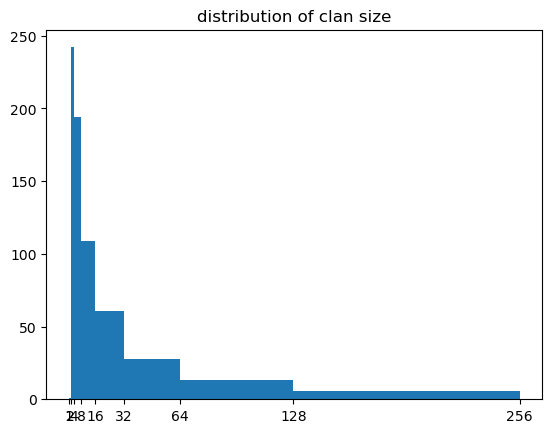

In [8]:
from collections import defaultdict
import matplotlib.pyplot as plt
tmp=defaultdict(int)
for u, v, data in G.edges(data=True):
    if data['label']=='hasMember':
        tmp[u]+=1

bins = [2**i for i in range(9)]
plt.hist(tmp.values(),bins=bins)
plt.xticks(bins, labels=[str(bin) for bin in bins])
plt.title('distribution of clan size')
plt.show()

In [9]:
existing_domains=[]
holder=0
for u, v, data in G.edges(data=True):
    if data['label']=='hasMember':
        if v not in existing_domains:
            existing_domains.append(v)
        else:
            print(f'double affiliation:{v}')
            holder=1
if not holder:
    print("no double affiliation.")

no double affiliation.


Text(0.5, 1.0, 'score distribution. lg transform')

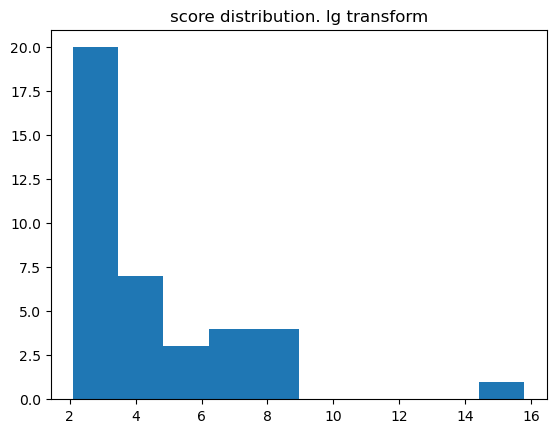

In [27]:
from math import log
clan='CL0001'
connected_nodes = [] #clan
for u, v, data in G.edges(data=True):
    if u== clan and data.get('label') == 'hasMember':
        connected_nodes.append(v)
subG:nx.DiGraph = G.subgraph(connected_nodes)
plt.hist([log(i[2],0.1) for i in subG.edges.data('score')])
plt.title('score distribution. log transform')

In [29]:
G.nodes[clan]

{'label': 'clan',
 'name': 'EGF',
 'description': 'Members of this clan all belong to the EGF superfamily.  This particular superfamily is characterised as having least 6 cysteine residues.                                                           These cysteines form disulphide bonds, in the order 1-3, 2-4, 5-6, which are essential for the stability of the EGF fold. These  disulphide bonds are stacked in a ladder-like arrangement. The Laminin EGF family is distinguished by having an an additional disulphide bond. The function of the domains within this family remains unclear, but they are thought to largely perform a structural role. More often than not, these domains are arranged in tandem repeats in extracellular proteins.'}

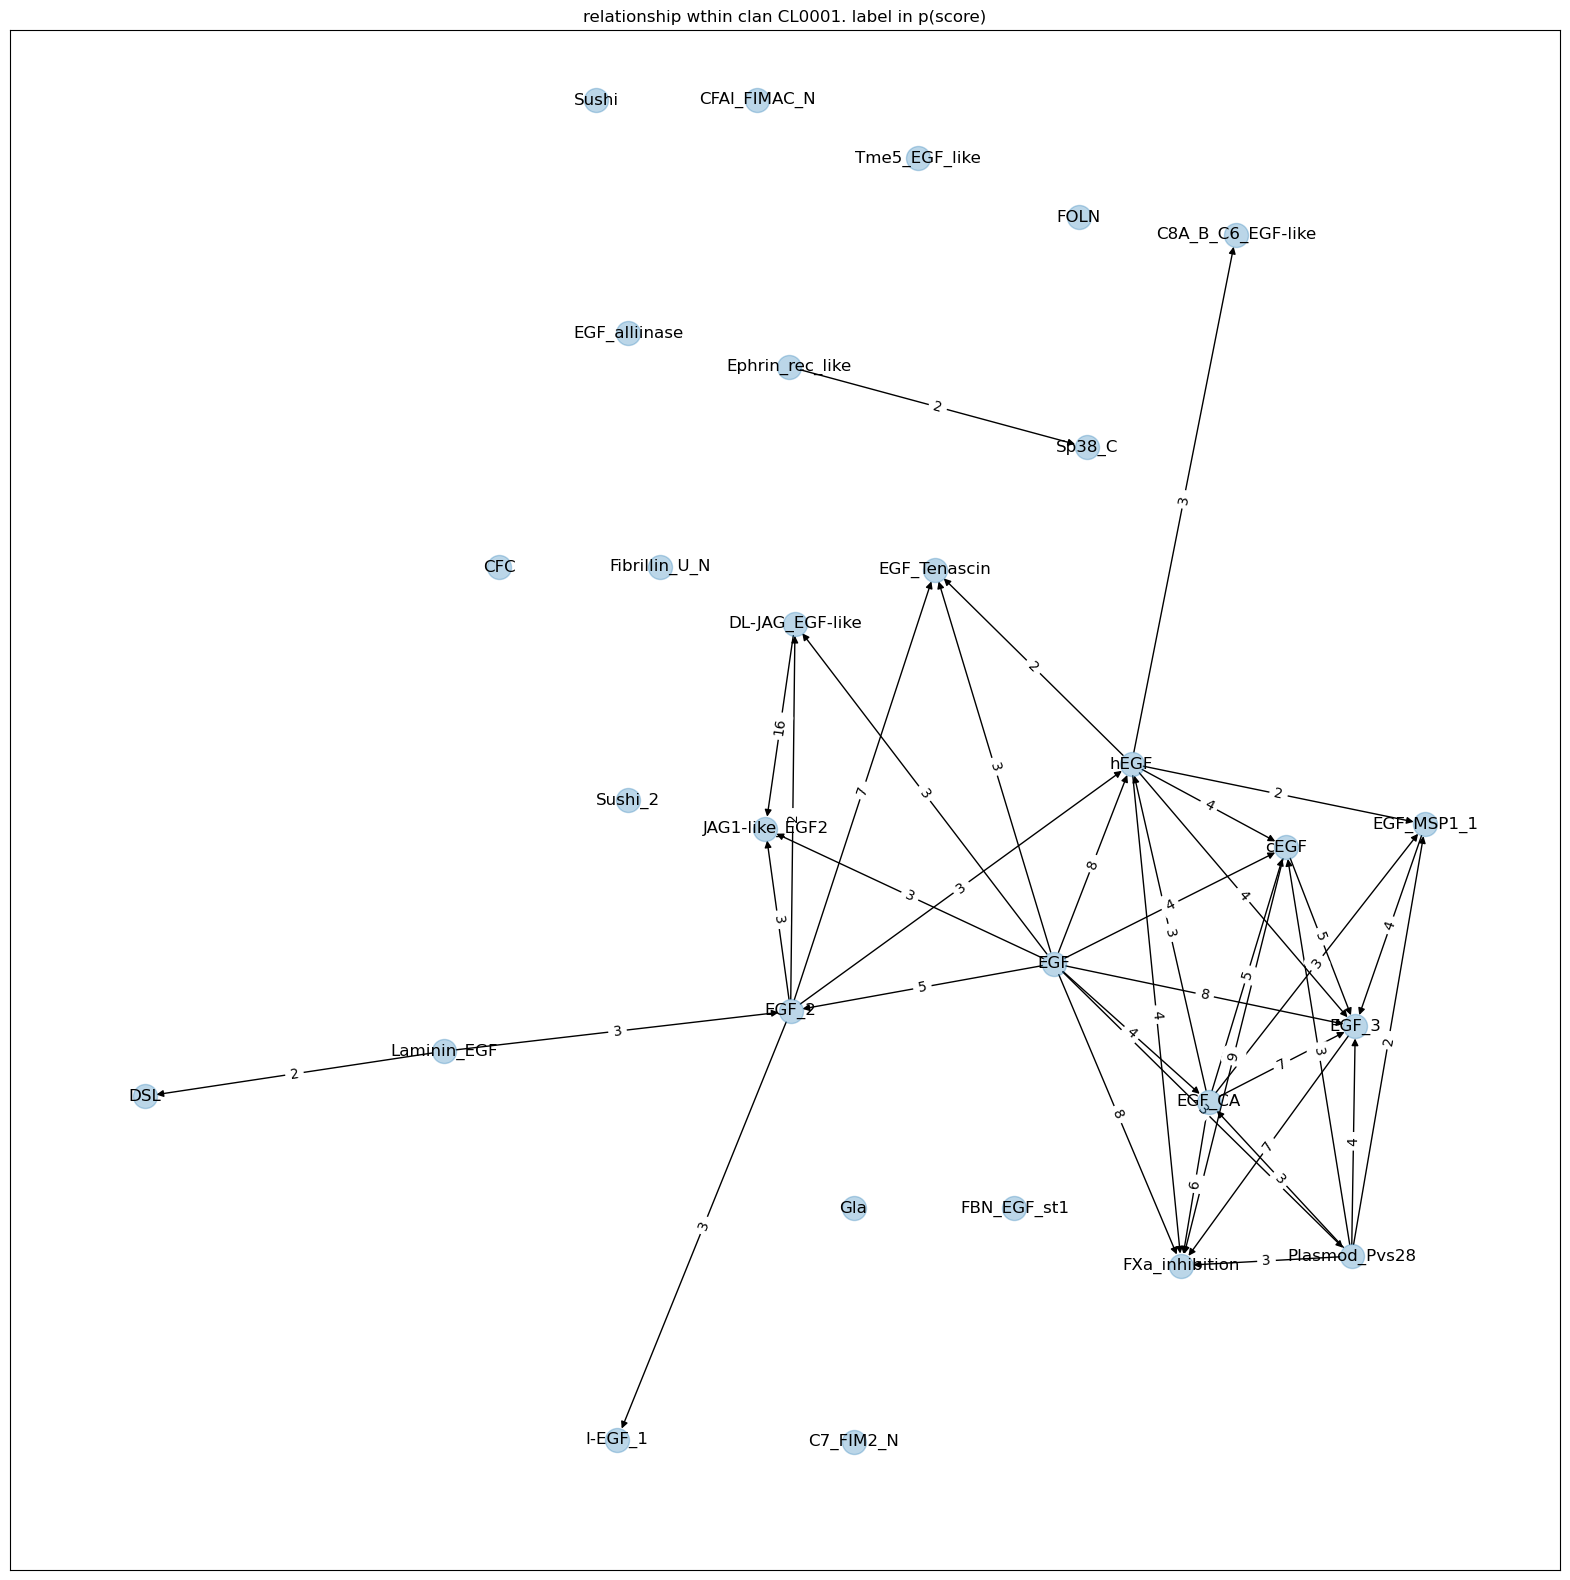

In [28]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes


for u, v, data in subG.edges(data=True):
    data['weight']=-log(data['score'],15)
    data['len']=max(1,log(data['score'],0.1))
fig,axs=plt.subplots(1,1,figsize=(20,20))
ax:Axes=axs
# nx.draw(subG)
linewidths=[min(-log(i['score'],15),10) for i in subG.edges.values()]
# pos=nx.spring_layout(subG,weight='weight',iterations=20,k=1/len(subG.nodes)**0.3)
pos=nx.nx_agraph.graphviz_layout(subG,'fdp')

nx.draw_networkx_nodes(subG, pos,ax=ax,alpha=0.3)
nx.draw_networkx_edges(subG, pos,arrows=True,ax=ax) #,width=linewidths
nx.draw_networkx_labels(subG,pos,labels={k:i['name'] for k,i in subG.nodes.items()},ax=ax)
nx.draw_networkx_edge_labels(subG, pos,{(u,v):f'{-log(data['score'],10):.0f}' for u, v, data in subG.edges(data=True)})
ax.set_title(f'relationship wthin clan {clan}. label in p(score)')
fig.show()

Sandbox to play with DiGraph

In [33]:
G.nodes['PF00008']

{'label': 'entry', 'name': 'EGF', 'description': 'EGF'}

In [34]:
G.nodes['CL0001']

{'label': 'clan',
 'name': 'EGF',
 'description': 'Members of this clan all belong to the EGF superfamily.  This particular superfamily is characterised as having least 6 cysteine residues.                                                           These cysteines form disulphide bonds, in the order 1-3, 2-4, 5-6, which are essential for the stability of the EGF fold. These  disulphide bonds are stacked in a ladder-like arrangement. The Laminin EGF family is distinguished by having an an additional disulphide bond. The function of the domains within this family remains unclear, but they are thought to largely perform a structural role. More often than not, these domains are arranged in tandem repeats in extracellular proteins.'}

In [35]:
G._succ['PF00053']

{'PF01414': {'label': 'hasLink',
  'score': 0.0051,
  'weight': 1.949193828498244,
  'len': 2.2924298239020637},
 'PF07974': {'label': 'hasLink',
  'score': 0.0031,
  'weight': 2.1330303127837102,
  'len': 2.5086383061657274}}

In [38]:
[i for i in G.neighbors('PF00053')]

['PF01414', 'PF07974']

In [36]:
G._succ['PF01414']

{}

In [39]:
[i for i in G.neighbors('PF01414')]

[]

In [41]:
G.in_edges('PF01414')

InEdgeDataView([('CL0001', 'PF01414'), ('PF00053', 'PF01414')])

In [40]:
G.out_edges("PF00053")

OutEdgeDataView([('PF00053', 'PF01414'), ('PF00053', 'PF07974')])